In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = set(stopwords.words('english'))

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [2]:
from dirtojsonl import process_directory

process_directory('c:\\tools\\code\\ResumeAnalytics\\Candidate Resumes', 'candidate.jsonl')
process_directory('c:\\tools\\code\\ResumeAnalytics\\Target Resumes', 'target.jsonl')
process_directory('c:\\tools\\code\\ResumeAnalytics\\Other Resumes', 'other.jsonl')

import json
with open('candidate.jsonl', 'r') as cf, open('target.jsonl', 'r') as tf, open('other.jsonl', 'r') as of:
  candidate = [json.loads(line) for line in cf]
  target = [json.loads(line) for line in tf]
  other = [json.loads(line) for line in of]
    
mashed_target = ''
doc_set = []
other_set = []
for t in target:
  doc_set.append(t['content'])
for o in other:
  other_set.append(o['content'])

can_set = []
for c in candidate:
  can_set.append(c['content'])


In [3]:

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# Do it again for other list
for i in other_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
    
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

# Remove extreme tokens from the dictionary
dictionary.filter_extremes(no_below=2, no_above=0.9, keep_n=100000)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# Seed the randomness so changes are more easily apparent (best practice)
import numpy
import random
numpy.random.seed(1)
random.seed(1)

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=30)

In [4]:
import math

# Define Jensen Shannon Distance
def js_distance(x,y): #Square root of Jensen-shannon divergence
    import warnings
    warnings.filterwarnings("ignore", category = RuntimeWarning)
    x = numpy.array(x)
    y = numpy.array(y)
    d1 = x*numpy.log2(2*x/(x+y))
    d2 = y*numpy.log2(2*y/(x+y))
    d1[numpy.isnan(d1)] = 0
    d2[numpy.isnan(d2)] = 0
    div = 0.5*numpy.sum(d1+d2)
    dist = math.sqrt(div)
    return dist

def doc_similarity(targ, comp):
    d = dict(comp)
    x = []
    y = []
    for topic in targ:
        if topic[0] in d:
            x.append(topic[1])
            y.append(d[topic[0]])
    return js_distance(x, y)

In [5]:
x = [(1, 1), (2, 2), (3, 3)]
d = dict(x)
if 4 in d:
    print("hi")


In [6]:
print (ldamodel.print_topics(num_topics = 10, num_words = 8))

[(0, '0.015*manag + 0.010*support + 0.010*execut + 0.010*account + 0.009*oper + 0.009*offic + 0.009*plan + 0.009*program'), (1, '0.020*project + 0.011*develop + 0.010*librari + 0.010*app + 0.009*work + 0.009*end + 0.008*help + 0.008*design'), (2, '0.023*develop + 0.018*databas + 0.014*data + 0.012*sql + 0.011*support + 0.011*design + 0.011*inform + 0.010*softwar'), (3, '0.017*develop + 0.015*use + 0.012*data + 0.011*comput + 0.011*java + 0.011*program + 0.009*design + 0.009*2014'), (4, '0.020*develop + 0.015*2014 + 0.014*year + 0.013*use + 0.012*system + 0.011*game + 0.011*work + 0.011*softwar'), (5, '0.020*manag + 0.013*support + 0.010*plan + 0.009*develop + 0.009*team + 0.009*document + 0.008*booz + 0.008*project'), (6, '0.020*year + 0.017*1 + 0.017*yr + 0.016*2 + 0.015*2012 + 0.015*softwar + 0.014*use + 0.014*manag'), (7, '0.014*year + 0.012*work + 0.011*1 + 0.010*intern + 0.010*team + 0.010*manag + 0.009*2013 + 0.008*2012'), (8, '0.026*develop + 0.012*applic + 0.011*softwar + 0.010

In [7]:
print (">>>>Target:<<<<\n")
# Get array of target topics
target_topics = []
for i in target:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    print (i['name'])
    topics = ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens))
    print (topics)
    target_topics.append(topics)
print (target_topics)
    
    
print ("\n\n>>>>Other:<<<<\n")
for i in other:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    #print (i['name'])
    #print (ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))    
    
print ("\n\n>>>>Candidates:<<<<\n")

for i in candidate:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    i['distance'] = 0
    for t in target_topics:
        i['distance'] = i['distance'] + doc_similarity(t, ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))
    # divide to obtain average distance to all target resumes
    # i['distance'] = i['distance'] / len(target_topics) Except this seems to vary by doc
    print (i['name'] + ": " + str(i['distance']))
    print (ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))



>>>>Target:<<<<

Brandon Herzog Resume 2010.txt
[(3, 0.99637013970265298)]
DrewChenResume.txt
[(0, 0.10228328272709294), (3, 0.56917373862032494), (8, 0.32558870045782551)]
Kyle Shaw Resume 2016.txt
[(1, 0.99867817024138505)]
Resume_Alejandro_Hired.txt
[(3, 0.93849152544215142), (9, 0.059112847079818544)]
ToddOldResume.txt
[(3, 0.99482662627587792)]
Matthew Daye_resume.docx
[(3, 0.31650303011479436), (7, 0.21923930959351409), (9, 0.46127827574169156)]
[[(3, 0.99637013970265298)], [(0, 0.10228328272709294), (3, 0.56917373862032494), (8, 0.32558870045782551)], [(1, 0.99867817024138505)], [(3, 0.93849152544215142), (9, 0.059112847079818544)], [(3, 0.99482662627587792)], [(3, 0.31650303011479436), (7, 0.21923930959351409), (9, 0.46127827574169156)]]


>>>>Other:<<<<



>>>>Candidates:<<<<

Aberra Aimen 7494924 Resume.txt: 2.196495893036046
[(0, 0.037744083081862521), (1, 0.065350628281215115), (3, 0.35697926637458077), (5, 0.029718590064196051), (6, 0.090603041606056908), (7, 0.10446896164

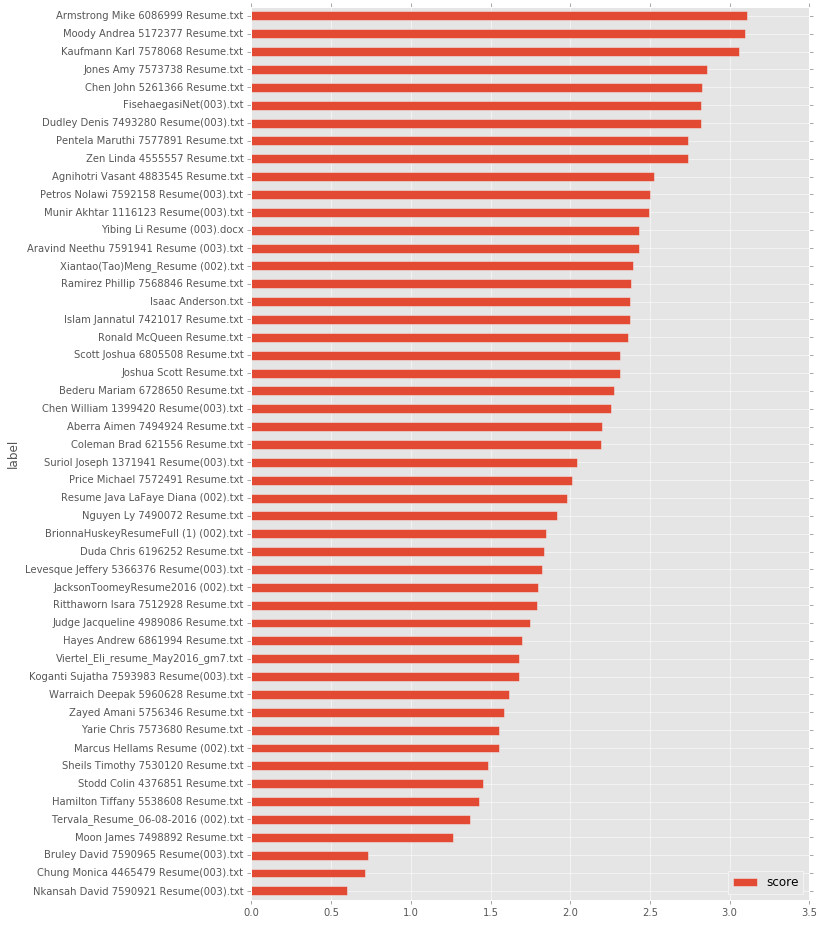

In [8]:
%matplotlib inline
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 16.0)

result = []
for i in range(len(candidate)):
    result.append((candidate[i]['name'], candidate[i]['distance']))
result = sorted(result, key=lambda x: x[1], reverse=False)

df = pd.DataFrame(result, columns=['label', 'score'])
df[:50].plot(kind='barh', x='label', y='score');